In [1]:
!pip install xvfbwrapper
!pip install ffmpeg-python
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
!pip install --upgrade tensorflow-probability
!pip install tf-agents
!pip install 'pybullet==2.4.2'
try:
    %tensorflow_version 2.x
except:
    pass

Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Looking in indexes: https://pypi.org/simple, https://artifactory.spotify.net/artifactory/api/pypi/pypi/simple/
Requirement already up-to-date: tensorflow-probability in /Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages (0.9.0)
Looking in indexes: https://pypi.org/simple, https://artifactory.spo

  Created wheel for pybullet: filename=pybullet-2.4.2-cp37-cp37m-macosx_10_14_x86_64.whl size=26187173 sha256=a709b92941994cf3865220a343b9b7424cf763e7945e46c435d8dd93b515fa99
  Stored in directory: /Users/lingh/Library/Caches/pip/wheels/15/b5/9c/5bfa43db629abe7647bcfc66474412d44f7d033f1eb8a073f8
Successfully built pybullet


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_pybullet
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [3]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 30 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}


current_dir=/Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/pybullet_envs/bullet
urdf_root=/Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/pybullet_data
options= 


/Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


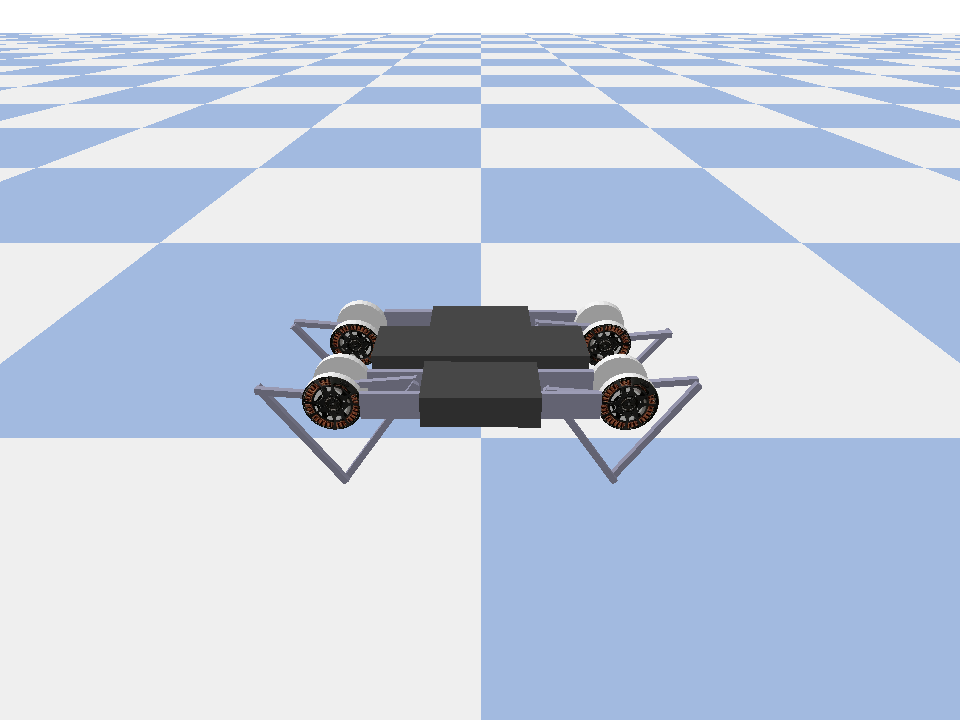

In [4]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


In [6]:
train_py_env = suite_pybullet.load(env_name)
eval_py_env = suite_pybullet.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

urdf_root=/Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/pybullet_data
options= 
urdf_root=/Users/lingh/.pyenv/versions/3.7.0/envs/my-virtual-env-3.7.0/lib/python3.7/site-packages/pybullet_data
options= 


In [7]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

In [8]:
def normal_projection_net(action_spec,init_means_output_factor=0.1):
    return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      std_transform=sac_agent.std_clip_transform,
      scale_distribution=True)


actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

In [9]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)
tf_agent.initialize()

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [10]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
collect_policy = tf_agent.collect_policy

In [11]:
def compute_avg_return(environment, policy, num_episodes=5):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

compute_avg_return(eval_env, eval_policy, num_eval_episodes)

-0.032851472

In [12]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [13]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


(TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00309743], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
 array([[ 1.6487161e+00,  1.6340679e+00,  8.8088202e-01,  2.2494740e+00,
          2.6844244e+00,  1.3313968e+00,  1.3466263e+00,  2.1452749e+00,
          3.9444273e+00,  7.8645868e+00,  9.3219862e+00,  1.7800856e+01,
         -2.1318195e+01, -2.8725765e+01,  1.4374667e+01, -2.9580137e+01,
          1.6530670e+00,  7.9708052e-01,  5.6999998e+00,  3.1160102e+00,
         -3.1182399e+00, -3.6084168e+00,  5.6999998e+00, -4.3948798e+00,
         -8.1326015e-02, -3.9576154e-02, -1.5343886e-02,  9.9578327e-01]],
       dtype=float32)>), ())

In [14]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

### Training the agent

In [15]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

In [17]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 5000: loss = -61.93603515625
step = 10000: loss = -69.89100646972656
step = 10000: Average Return = -1.3491262197494507


(-1.4147499477490784, 0.028972068242728716)

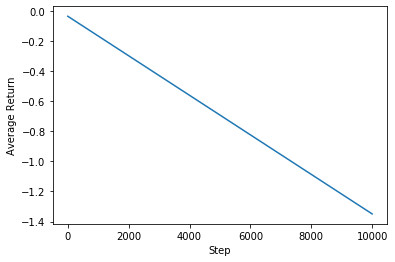

In [19]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [21]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [ ]:
num_episodes = 3
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
    while not time_step.is_last():
        action_step = tf_agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())

embed_mp4(video_filename)